In [ ]:
library(repr)
library(dplyr)
library(corrplot)
library(ggplot2)
library(stats)
library(car)
library(ggpubr)
library(PerformanceAnalytics)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


corrplot 0.92 loaded

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



######################### Warning from 'xts' package ##########################
#                                                                             #
# The dplyr lag() function breaks how base R's lag() function is supposed to  #
# work, which breaks lag(my_xts). Calls to lag(my_xts) that you type or       #
# source() into this session won't work correctly.                            #
#                                                                     

In [ ]:
data <- read.csv("/content/HousePrices/train.csv")

In [ ]:
summary(data)

       Id           MSSubClass      MSZoning          LotFrontage    
 Min.   :   1.0   Min.   : 20.0   Length:1460        Min.   : 21.00  
 1st Qu.: 365.8   1st Qu.: 20.0   Class :character   1st Qu.: 59.00  
 Median : 730.5   Median : 50.0   Mode  :character   Median : 69.00  
 Mean   : 730.5   Mean   : 56.9                      Mean   : 70.05  
 3rd Qu.:1095.2   3rd Qu.: 70.0                      3rd Qu.: 80.00  
 Max.   :1460.0   Max.   :190.0                      Max.   :313.00  
                                                     NA's   :259     
    LotArea          Street             Alley             LotShape        
 Min.   :  1300   Length:1460        Length:1460        Length:1460       
 1st Qu.:  7554   Class :character   Class :character   Class :character  
 Median :  9478   Mode  :character   Mode  :character   Mode  :character  
 Mean   : 10517                                                           
 3rd Qu.: 11602                                                  

# Data Cleaning

### **1) Convert and group by data type**
We split the data into numeric data and categorical:

In [ ]:
# numeric data only
numeric_data <- select_if(data, is.numeric)

In [ ]:
# manually removing columns that are not actually numeric, but just hve numbers as values
numeric_data <- select(numeric_data, -MoSold, -MSSubClass, -MasVnrArea, -BsmtFinSF1, -BsmtFinSF2, -LowQualFinSF, -BsmtFullBath, -BsmtHalfBath, -FullBath, -HalfBath, -BedroomAbvGr, -KitchenAbvGr, -TotRmsAbvGrd, -Fireplaces, -GarageCars, -EnclosedPorch, -X3SsnPorch, -ScreenPorch, -MiscVal)

In [ ]:
# convert to data frame:
dframe <- data.frame(numeric_data)

### **2) Remove 'NA' values:**

In [ ]:
# remove NA values in relevant columns (the ones which have NA values and that we will use in our analysis):
dframe <- dframe[complete.cases(dframe$LotFrontage), ]
dframe <- dframe[complete.cases(dframe$GarageYrBlt), ]

### **3) Checking for duplicated values:**

In [ ]:
# check for duplicates
duplicates <- dframe[duplicated(data),]
any(duplicates)

[1] FALSE

### **4) Checking the column headers:**

In [ ]:
colnames(dframe)

[1] "Id"           "LotFrontage"  "LotArea"      "OverallQual"  "OverallCond" 
 [6] "YearBuilt"    "YearRemodAdd" "BsmtUnfSF"    "TotalBsmtSF"  "X1stFlrSF"   
[11] "X2ndFlrSF"    "GrLivArea"    "GarageYrBlt"  "GarageArea"   "WoodDeckSF"  
[16] "OpenPorchSF"  "PoolArea"     "YrSold"       "SalePrice"

# Preliminary Numerical Analysis

## Preliminary Correlation Matrix

In [ ]:
# Generate the correlation matrix
cor_matrix <- cor(dframe)
# ordering matrix
order_ind <- order(abs(cor_matrix[,ncol(dframe)]), decreasing=TRUE)
reorder_mat <- cor_matrix[order_ind, order_ind]

In [ ]:
## plotting:
# corrplot(reorder_mat, method="color", addCoef.col="black", number.cex=0.5, tl.cex=0.5)

## Choosing Numerical Variables

In [ ]:
# Creating a new column "totalSF"
dframe$totalSF <- dframe$GrLivArea + dframe$X1stFlrSF + dframe$X2ndFlrSF

# Remove added SFs
dframe <- select(dframe, -GrLivArea, -X1stFlrSF, -X2ndFlrSF)

In [ ]:
# Filtering df by pool or no pool:
havepool <- subset(dframe, PoolArea != 0)
nopool <- subset(dframe, PoolArea == 0)

In [ ]:
## HOUSES W/O POOL <<-- because only 6 houses with a pool
chosen <- nopool[,c("Id", "LotFrontage", "LotArea", "GarageArea", "YearBuilt", "TotalBsmtSF", "totalSF", "SalePrice")]
col_names <- names(chosen)

## Histograms

In [ ]:
## will not print:
if(FALSE) {
	par(mfrow=c(2,4))
	for (col in col_names) {
		if (col == "Id") {next}
		hist(chosen[[col]], main=col, xlab=col)
	}
}

## Log Transformations

In [ ]:
## initializing new "log" dataframe:
log_chosen <- data.frame( matrix( ncol=ncol(chosen), nrow=nrow(chosen) ) )

for (col in colnames(chosen)) {
	## making sure YearBuilt and Id aren't transformed:
	if (col == "YearBuilt" | col == "Id") {
		log_chosen[[paste0(col)]] <- chosen[[col]]
	} else {
		## transforming:
		log_chosen[[paste0("log", col)]] <- log(chosen[[col]])
	}
}

## removing some randoly appearing columns lol
log_chosen <- subset(log_chosen, select = -c(X1, X2, X3, X4, X5, X6, X7, X8))
head(log_chosen)
before_outlier <- nrow(log_chosen)
print(before_outlier)

,Id,logLotFrontage,logLotArea,logGarageArea,YearBuilt,logTotalBsmtSF,logtotalSF,logSalePrice
,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,1,4.174387,9.041922,6.306275,2003,6.752270,8.137396,12.24769
2,2,4.382027,9.169518,6.131226,1976,7.140453,7.833600,12.10901
3,3,4.219508,9.328123,6.410175,2001,6.824374,8.180881,12.31717
4,4,4.094345,9.164296,6.464588,1915,6.628041,8.141481,11.84940
5,5,4.430817,9.565214,6.728629,2000,7.043160,8.388450,12.42922
6,6,4.442651,9.554993,6.173786,1993,6.679599,7.909857,11.87060


[1] 1121


## Log Histograms

In [ ]:
## wil not print:
if (FALSE) {

par(mfrow=c(2,4))

for(col in colnames(log_chosen)) {

	## YearBuilt does not work with a log transform
	if (col == "YearBuilt" | col == "Id") {
		next
	}
	hist(log_chosen[[col]], main=col, xlab=col)
}

## plotting YearBuilt as it is since log doesn't work with it
hist(log_chosen[["YearBuilt"]], main="YearBuilt", xlab="YearBuilt")

}

## Merge with categorical data

In [ ]:
## adding the categorical columns by the Id of the remaining houses
merged <- merge(log_chosen, data[, c("Id", "LotShape", "MSSubClass", "MasVnrType", "HouseStyle")], by="Id")
head(merged, 20)
nrow(merged)

,Id,logLotFrontage,logLotArea,logGarageArea,YearBuilt,logTotalBsmtSF,logtotalSF,logSalePrice,LotShape,MSSubClass,MasVnrType,HouseStyle
,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<chr>
1,1,4.174387,9.041922,6.306275,2003,6.752270,8.137396,12.24769,Reg,60,BrkFace,2Story
2,2,4.382027,9.169518,6.131226,1976,7.140453,7.833600,12.10901,Reg,20,None,1Story
3,3,4.219508,9.328123,6.410175,2001,6.824374,8.180881,12.31717,IR1,60,BrkFace,2Story
4,4,4.094345,9.164296,6.464588,1915,6.628041,8.141481,11.84940,IR1,70,None,2Story
5,5,4.430817,9.565214,6.728629,2000,7.043160,8.388450,12.42922,IR1,60,BrkFace,2Story
6,6,4.442651,9.554993,6.173786,1993,6.679599,7.909857,11.87060,IR1,50,None,1.5Fin
7,7,4.317488,9.218705,6.455199,2004,7.430114,8.127995,12.63460,Reg,20,Stone,1Story
8,9,3.931826,8.719317,6.148468,1931,6.858565,8.174139,11.77452,Reg,50,None,1.5Fin
9,10,3.912023,8.911934,5.323010,1939,6.898715,7.675082,11.67844,Reg,190,None,1.5Unf


[1] 1121

# Removing irrelevant and NA values

In [ ]:
## removing Planned Unit Developments in MSSubClass
filtered <- subset(merged, !(MSSubClass %in% c(120, 150, 160, 180, 190)))
nrow(filtered)

filtered <- na.omit(filtered, MasVnrType)

[1] 976

## Remove outliers from Log

In [ ]:
for (col in 1:ncol(log_chosen)) {
	x <- log_chosen[,col]

	q1 <- quantile(x, 0.25)
	q3 <- quantile(x, 0.75)
	iqr <- q3-q1
	lower <- q1 - 1.5*iqr
	upper <- q3 + 1.5*iqr

	## if too low or too high, replace with NA
	x <- ifelse(x<lower | x>upper, NA, x)

	## removing rows w NA
	log_chosen <- log_chosen[complete.cases(x),]

}

head(log_chosen)
after_outlier <- nrow(log_chosen)
print(after_outlier)

outliers <- before_outlier - after_outlier
print(outliers)

,Id,logLotFrontage,logLotArea,logGarageArea,YearBuilt,logTotalBsmtSF,logtotalSF,logSalePrice
,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,1,4.174387,9.041922,6.306275,2003,6.752270,8.137396,12.24769
2,2,4.382027,9.169518,6.131226,1976,7.140453,7.833600,12.10901
3,3,4.219508,9.328123,6.410175,2001,6.824374,8.180881,12.31717
4,4,4.094345,9.164296,6.464588,1915,6.628041,8.141481,11.84940
5,5,4.430817,9.565214,6.728629,2000,7.043160,8.388450,12.42922
6,6,4.442651,9.554993,6.173786,1993,6.679599,7.909857,11.87060


[1] 916
[1] 205


## Log boxplots after outliers removed

In [ ]:
## will not print:
if (FALSE) {

par(mfrow=c(2,4))
for (col in colnames(log_chosen)) {
	## don't plot irrelevant stuff
	if (col == "Id") {next}
	boxplot(log_chosen[,col], main=col)
}

}

## Correlation Matrix

In [ ]:
## CORRELATION WITH LOG (NO OUTLIERS):


cor_mat_chosen <- cor(log_chosen)
order_ind_chosen <- order(abs(cor_mat_chosen[,ncol(log_chosen)]), decreasing=TRUE)
reorder_mat_chosen <- cor_mat_chosen[order_ind_chosen, order_ind_chosen]


## ORDERING the df (chosen variables) by correlation
corr_values <- cor_mat_chosen["logSalePrice", -ncol(log_chosen)]
corr_order <- order(-abs(corr_values))
log_chosen <- log_chosen[,c("logSalePrice", names(log_chosen)[corr_order])]
head(log_chosen)

## will not print:
# par(mfrow=c(1,1))
# corrplot(reorder_mat_chosen, method="color", addCoef.col="black", number.cex=0.7, tl.cex=0.7)



,logSalePrice,logtotalSF,YearBuilt,logGarageArea,logTotalBsmtSF,logLotArea,logLotFrontage,Id
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,12.24769,8.137396,2003,6.306275,6.752270,9.041922,4.174387,1
2,12.10901,7.833600,1976,6.131226,7.140453,9.169518,4.382027,2
3,12.31717,8.180881,2001,6.410175,6.824374,9.328123,4.219508,3
4,11.84940,8.141481,1915,6.464588,6.628041,9.164296,4.094345,4
5,12.42922,8.388450,2000,6.728629,7.043160,9.565214,4.430817,5
6,11.87060,7.909857,1993,6.173786,6.679599,9.554993,4.442651,6


## Regression of Chosen Numerical Vars

In [ ]:
## will not print:
if (FALSE) {

par(mfrow=c(2,3))
y <- log_chosen$logSalePrice

for (col in 3:ncol(log_chosen)-1) {
	# if (col == "Id") {next}
	x <- log_chosen[,col]
	## plotting each graph
	plot(x, y, main=paste0("Plot of ", colnames(log_chosen)[col]), xlab=colnames(log_chosen)[col], ylab="logSalePrice")
	model <- lm(y ~ x)
	abline(model, col="red")
}

}


## corrplot matrix between all variables
# chart.Correlation(log_chosen, histogram='FALSE', pch=19, main="Corr Mat Plot")


# Spearman Correlation

In [ ]:
## spearman for YearBuilt and two other seemingly related variables
cor.test(log_chosen$YearBuilt, log_chosen$logGarageArea, method="spearman")
cor.test(log_chosen$YearBuilt, log_chosen$logTotalBsmtSF, method="spearman")

## spearman for YearBuilt vs logSalePrice
spear <- cor.test(log_chosen$YearBuilt, log_chosen$logSalePrice, method = "spearman")
print(spear)

## plotting above correlation
## will not print
if(FALSE) {
par(mfrow=c(1,1))
ggplot(log_chosen, aes(x=YearBuilt, y=logSalePrice)) +
	geom_point() + stat_smooth(method="lm", formula=y~x, se=FALSE) +
	stat_cor(method="spearman", label.x=1973, label.y=11.5, size=5, color="blue") +
	labs(title="Scatterplot of logSalePrice and YearBuilt with Spearman Correlation Coefficient")
}


Warning message in cor.test.default(log_chosen$YearBuilt, log_chosen$logGarageArea, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  log_chosen$YearBuilt and log_chosen$logGarageArea
S = 54559966, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.5740688 


Warning message in cor.test.default(log_chosen$YearBuilt, log_chosen$logTotalBsmtSF, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  log_chosen$YearBuilt and log_chosen$logTotalBsmtSF
S = 63178883, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.5067838 


Warning message in cor.test.default(log_chosen$YearBuilt, log_chosen$logSalePrice, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  log_chosen$YearBuilt and log_chosen$logSalePrice
S = 35409658, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.7235688 



# Categorical Data

### MSSubClass

,Id,logLotFrontage,logLotArea,logGarageArea,YearBuilt,logTotalBsmtSF,logtotalSF,logSalePrice,LotShape,MSSubClass,MasVnrType,HouseStyle
,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,1,4.174387,9.041922,6.306275,2003,6.752270,8.137396,12.24769,Reg,2story,BrkFace,2Story
2,2,4.382027,9.169518,6.131226,1976,7.140453,7.833600,12.10901,Reg,1story,None,1Story
3,3,4.219508,9.328123,6.410175,2001,6.824374,8.180881,12.31717,IR1,2story,BrkFace,2Story
4,4,4.094345,9.164296,6.464588,1915,6.628041,8.141481,11.84940,IR1,2story,None,2Story
5,5,4.430817,9.565214,6.728629,2000,7.043160,8.388450,12.42922,IR1,2story,BrkFace,2Story
6,6,4.442651,9.554993,6.173786,1993,6.679599,7.909857,11.87060,IR1,1story,None,1.5Fin
7,7,4.317488,9.218705,6.455199,2004,7.430114,8.127995,12.63460,Reg,1story,Stone,1Story
8,9,3.931826,8.719317,6.148468,1931,6.858565,8.174139,11.77452,Reg,1story,None,1.5Fin
10,11,4.248495,9.323669,5.950643,1965,6.946976,7.640123,11.77144,Reg,1story,None,1Story


[1] 971

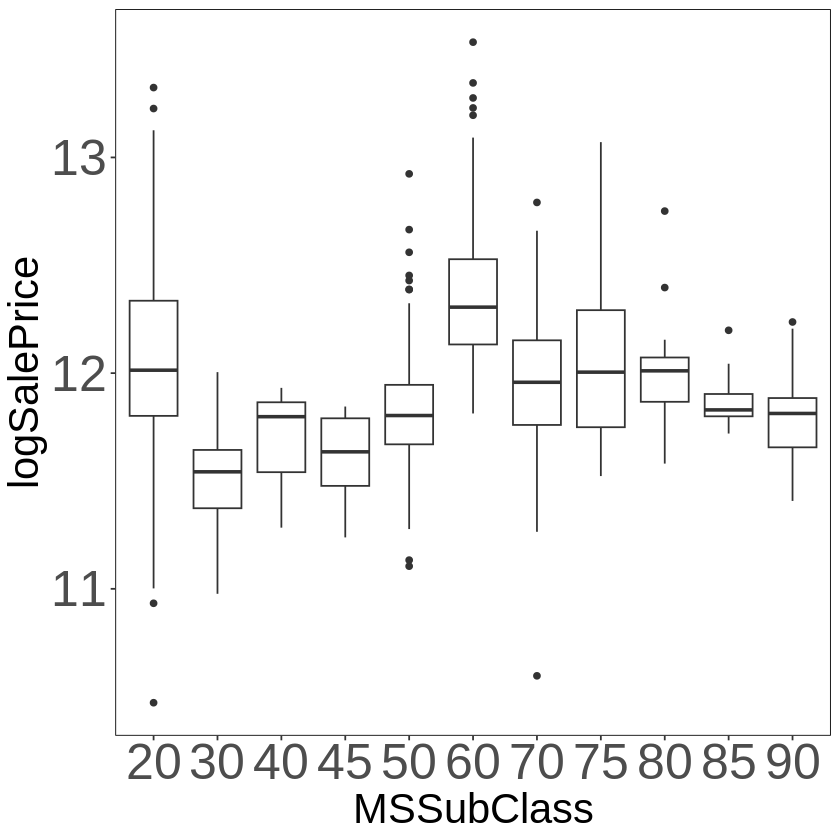

,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,14.01431,1.000263e-06
,968,NA,NA



	Kruskal-Wallis rank sum test

data:  logSalePrice by MSSubClass
Kruskal-Wallis chi-squared = 154.5, df = 2, p-value < 2.2e-16



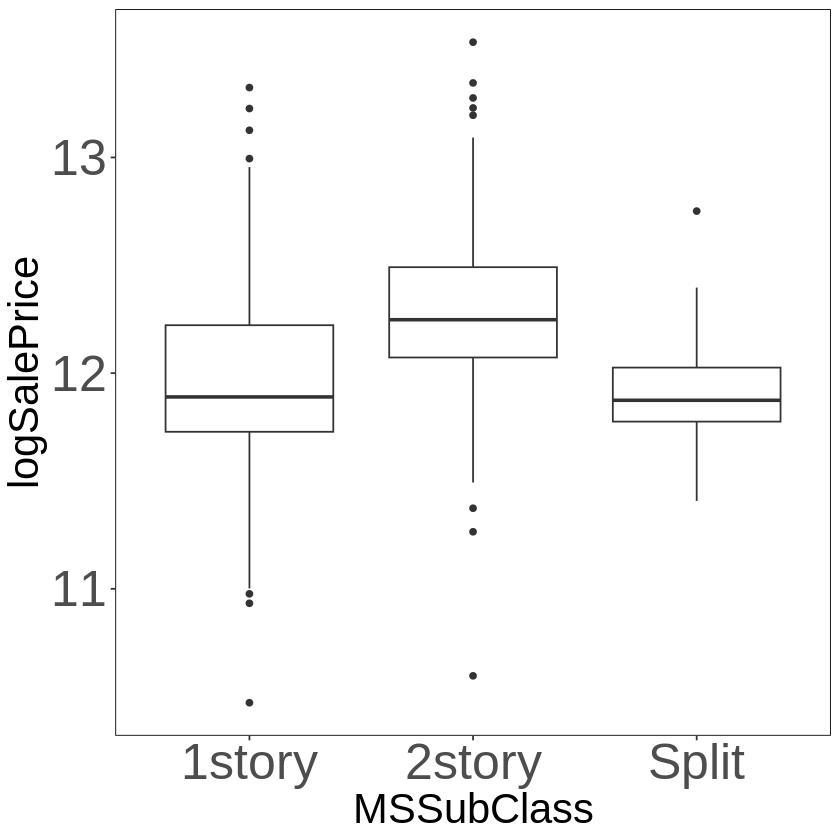

In [ ]:
## show boxplots without grouping
## converting MSSubClass values to "factor" data type
filtered$MSSubClass <- as.factor(filtered$MSSubClass)

par(mfrow=c(1,1))
ggplot(filtered, aes(x=MSSubClass, y=logSalePrice)) + geom_boxplot() + xlab("MSSubClass") + ylab("logSalePrice") + theme(axis.text = element_text(size=30), axis.title = element_text(size=25), panel.background = element_rect(fill = "white"), panel.border = element_rect(colour = "black", fill = NA))


## group the subcategories into larger ones


## combining the many subcategories of 1story, 2story and Split in MSSubClass
filtered$MSSubClass <- as.character(filtered$MSSubClass)
for (i in 1:nrow(filtered)) {
	## 1 story, 1.5 story = 1 story
	if (filtered$MSSubClass[i] %in% c("20", "30", "40", "45", "50")) {
		filtered$MSSubClass[i] <- "1story"
	}
	## 2 story, 2.5 story = 2 story
	if (filtered$MSSubClass[i] %in% c("60", "70", "75")) {
		filtered$MSSubClass[i] <- "2story"
	}
	## Others = Split level
	if (filtered$MSSubClass[i] %in% c("80", "85", "90")) {
		filtered$MSSubClass[i] <- "Split"
	}
}


head(filtered, 20)
nrow(filtered)



## Converting MSSubClass values to "factor" data type
filtered$MSSubClass <- as.factor(filtered$MSSubClass)

## box plots of each category's logSalePrice
par(mfrow=c(1,1))
ggplot(filtered, aes(x=MSSubClass, y=logSalePrice)) + geom_boxplot() + xlab("MSSubClass") + ylab("logSalePrice") + theme(axis.text = element_text(size=30), axis.title = element_text(size=25), panel.background = element_rect(fill = "white"), panel.border = element_rect(colour = "black", fill = NA))

## Are the variances of the subgroups equal?
leveneTest(logSalePrice ~ MSSubClass, data=filtered)
## extremely small p-value 4.29e-07
## variances unequal
## no anova
## kruskal-wallis instead

kw <- kruskal.test(logSalePrice ~ MSSubClass, data=filtered)
print(kw)
## small p-value 3.372e-07
## medians differ between groups

## MSSubClass matters in determining SalePrice.


### MasVnrType

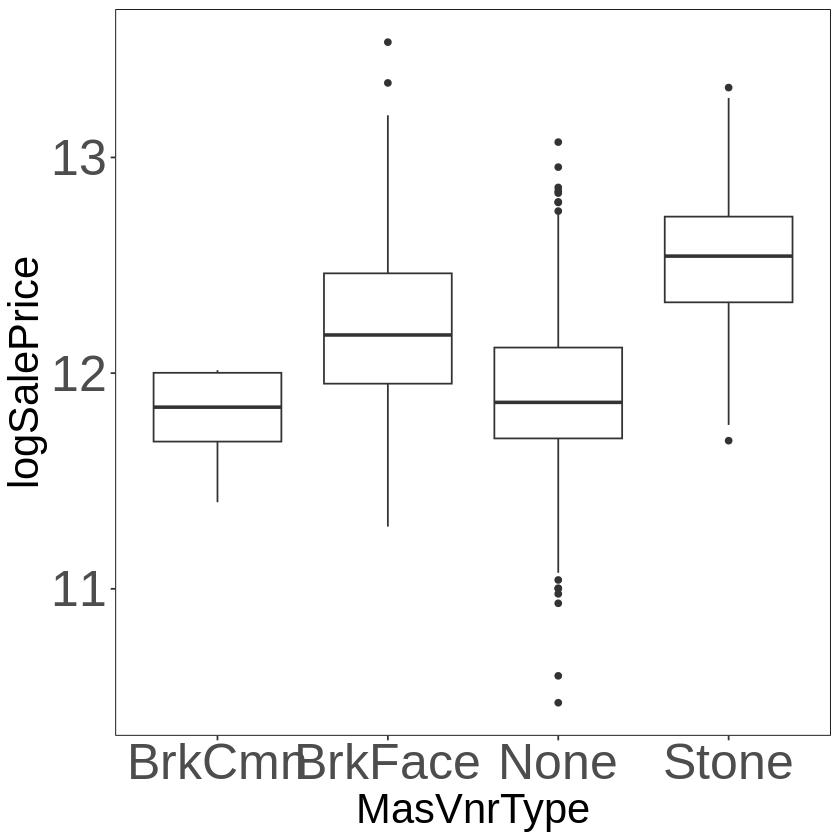

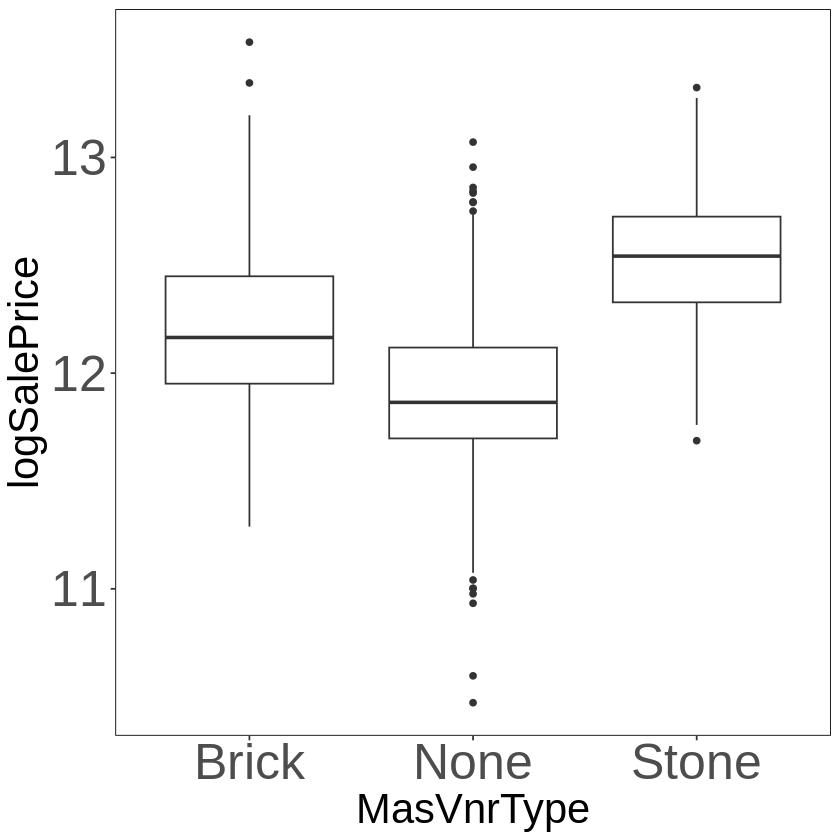

In [ ]:
par(mfrow=c(1,1))
ggplot(filtered, aes(x=MasVnrType, y=logSalePrice)) + geom_boxplot() + xlab("MasVnrType") + ylab("logSalePrice") + theme(axis.text = element_text(size=30), axis.title = element_text(size=25), panel.background = element_rect(fill = "white"), panel.border = element_rect(colour = "black", fill = NA))


## grouping brick
for (i in 1:nrow(filtered)) {
	if (filtered$MasVnrType[i] %in% c("BrkCmn", "BrkFace")) {
		filtered$MasVnrType[i] <- "Brick"
	}
}

## visualizing:
par(mfrow=c(1,1))
ggplot(filtered, aes(x=MasVnrType, y=logSalePrice)) + geom_boxplot() + xlab("MasVnrType") + ylab("logSalePrice") + theme(axis.text = element_text(size=30), axis.title = element_text(size=25), panel.background = element_rect(fill = "white"), panel.border = element_rect(colour = "black", fill = NA))


## test the variances:
### filtered$MasVnrType <- as.factor(filtered$MasVnrType)
###leveneTest(logSalePrice ~ MasVnrType, data = filtered)
## p-value is 0.1555
## variances are not the same
##

### LotShape

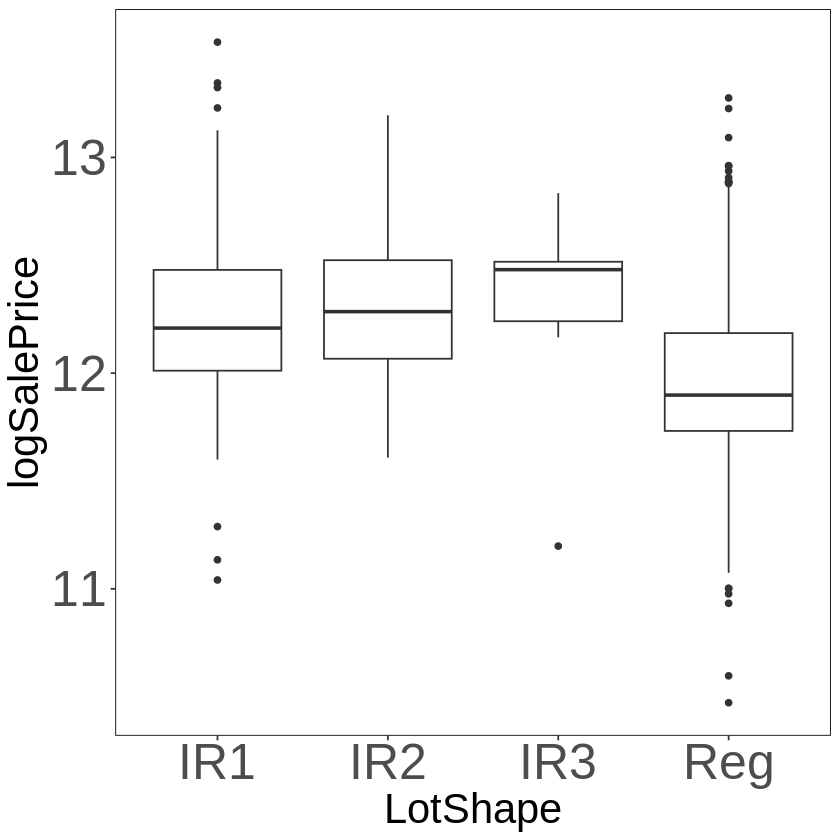


	F test to compare two variances

data:  group1 and group2
F = 0.95899, num df = 303, denom df = 666, p-value = 0.6791
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.7939559 1.1664893
sample estimates:
ratio of variances 
         0.9589895 



	Two Sample t-test

data:  group1 and group2
t = 11.043, df = 969, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.2377060 0.3404453
sample estimates:
mean of x mean of y 
 12.25597  11.96689 



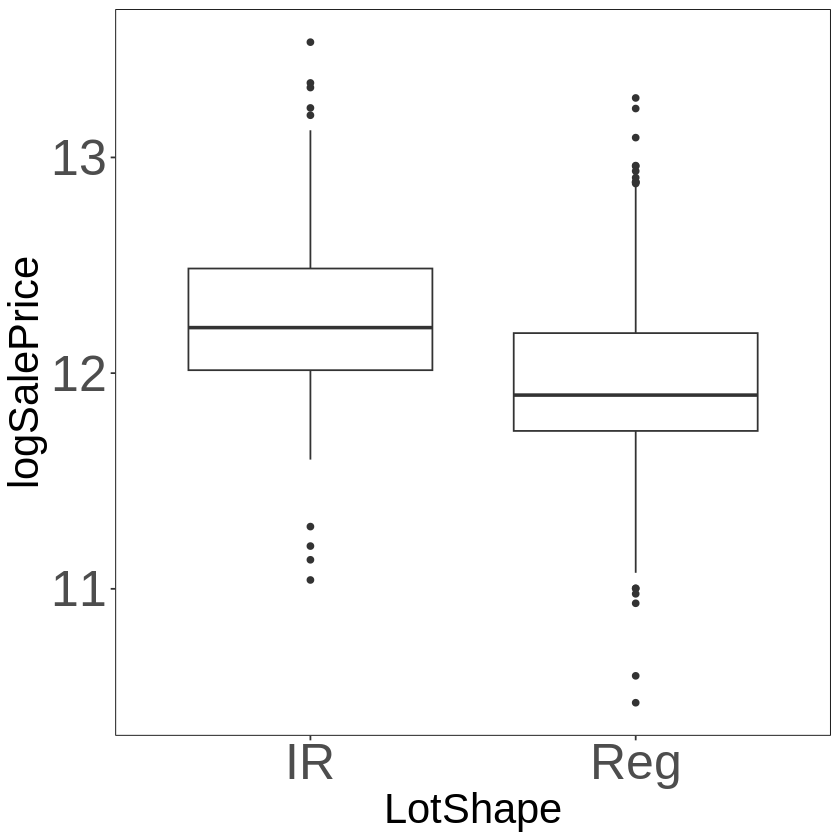

In [ ]:
## boxplots before grouping:
par(mfrow=c(1,1))
ggplot(filtered, aes(x=LotShape, y=logSalePrice)) + geom_boxplot() + xlab("LotShape") + ylab("logSalePrice") + theme(axis.text = element_text(size=30), axis.title = element_text(size=25), panel.background = element_rect(fill = "white"), panel.border = element_rect(colour = "black", fill = NA))

## grouping all irregulars
for (i in 1:nrow(filtered)) {
	if (filtered$LotShape[i] %in% c("IR1", "IR2", "IR3")) {
		filtered$LotShape[i] <- "IR"
	}
}

## visualizing:
par(mfrow=c(1,1))
ggplot(filtered, aes(x=LotShape, y=logSalePrice)) + geom_boxplot() + xlab("LotShape") + ylab("logSalePrice") + theme(axis.text = element_text(size=30), axis.title = element_text(size=25), panel.background = element_rect(fill = "white"), panel.border = element_rect(colour = "black", fill = NA))


## test the variances:
subset_data <- filtered[c("logSalePrice", "LotShape")]
group1 <- subset_data$logSalePrice[subset_data$LotShape == "IR"]
group2 <- subset_data$logSalePrice[subset_data$LotShape == "Reg"]

var.test(group1, group2)
## p-value is 0.052
## variances almost the same

## t-test
result <- t.test(group1, group2, var.equal=TRUE)
print(result)
## small p-value
## means are not the the same

## LotShape does matter

# HouseStyle

,Id,logLotFrontage,logLotArea,logGarageArea,YearBuilt,logTotalBsmtSF,logtotalSF,logSalePrice,LotShape,MSSubClass,MasVnrType,HouseStyle
,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<chr>,<chr>
1,1,4.174387,9.041922,6.306275,2003,6.752270,8.137396,12.24769,Reg,2story,Brick,2Floors
2,2,4.382027,9.169518,6.131226,1976,7.140453,7.833600,12.10901,Reg,1story,None,1Floor
3,3,4.219508,9.328123,6.410175,2001,6.824374,8.180881,12.31717,IR,2story,Brick,2Floors
4,4,4.094345,9.164296,6.464588,1915,6.628041,8.141481,11.84940,IR,2story,None,2Floors
5,5,4.430817,9.565214,6.728629,2000,7.043160,8.388450,12.42922,IR,2story,Brick,2Floors
6,6,4.442651,9.554993,6.173786,1993,6.679599,7.909857,11.87060,IR,1story,None,1Floor
7,7,4.317488,9.218705,6.455199,2004,7.430114,8.127995,12.63460,Reg,1story,Stone,1Floor
8,9,3.931826,8.719317,6.148468,1931,6.858565,8.174139,11.77452,Reg,1story,None,1Floor
10,11,4.248495,9.323669,5.950643,1965,6.946976,7.640123,11.77144,Reg,1story,None,1Floor


[1] 971

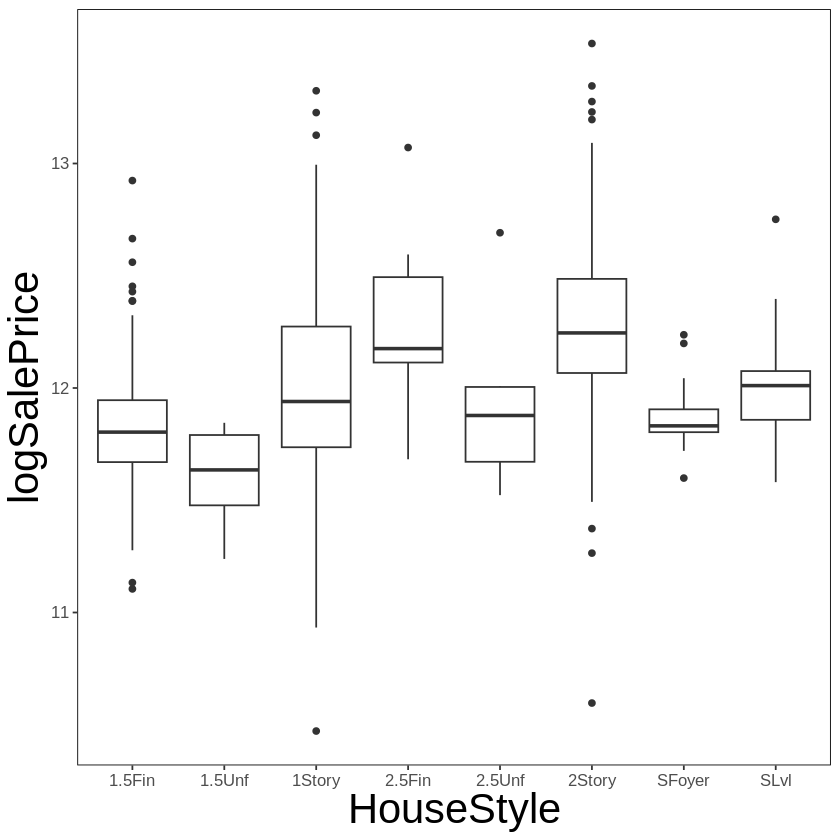

,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,10.88743,2.108862e-05
,968,NA,NA



	Kruskal-Wallis rank sum test

data:  logSalePrice by HouseStyle
Kruskal-Wallis chi-squared = 136.72, df = 2, p-value < 2.2e-16



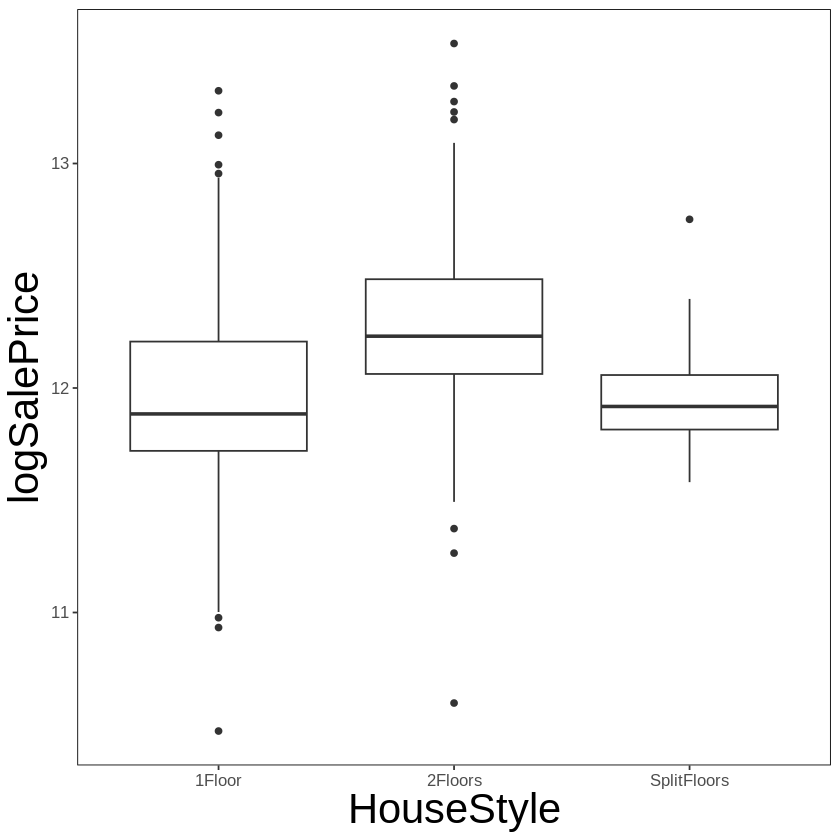

In [ ]:
## show boxplots without grouping
## converting HouseStyle values to "factor" data type
filtered$HouseStyle <- as.factor(filtered$HouseStyle)

par(mfrow=c(1,1))
hstyleplot1 <- ggplot(filtered, aes(x=HouseStyle, y=logSalePrice)) + geom_boxplot() + xlab("HouseStyle") + ylab("logSalePrice") + theme(axis.text = element_text(size=30), axis.title = element_text(size=25), panel.background = element_rect(fill = "white"), panel.border = element_rect(colour = "black", fill = NA))
hstyleplot1 + theme(axis.text = element_text(size = 10))


## group the subcategories into larger ones


## combining the many subcategories of 1story, 2story and Split in MSSubClass
filtered$HouseStyle <- as.character(filtered$HouseStyle)
for (i in 1:nrow(filtered)) {
	## 1 story, 1.5 Fin, 1.5 Unf = 1 story
	if (filtered$HouseStyle[i] %in% c("1Story", "1.5Fin", "1.5Unf")) {
		filtered$HouseStyle[i] <- "1Floor"
	}
	## 2 story, 2.5 Fin, 2.5 Unf = 2 story
	if (filtered$HouseStyle[i] %in% c("2Story","2.5Fin","2.5Unf")) {
		filtered$HouseStyle[i] <- "2Floors"
	}
	## Others = Split Foyer, Split level
	if (filtered$HouseStyle[i] %in% c("SFoyer", "SLvl")) {
		filtered$HouseStyle[i] <- "SplitFloors"
	}
}


head(filtered, 20)
nrow(filtered)



## Converting MSSubClass values to "factor" data type
filtered$HouseStyle <- as.factor(filtered$HouseStyle)

## box plots of each category's logSalePrice
par(mfrow=c(1,1))
hstyleplot2 <- ggplot(filtered, aes(x=HouseStyle, y=logSalePrice)) + geom_boxplot() + xlab("HouseStyle") + ylab("logSalePrice") + theme(axis.text = element_text(size=30), axis.title = element_text(size=25), panel.background = element_rect(fill = "white"), panel.border = element_rect(colour = "black", fill = NA))
hstyleplot2 + theme(axis.text = element_text(size = 10))


## Are the variances of the subgroups equal?
leveneTest(logSalePrice ~ HouseStyle, data=filtered)
## extremely small p-value 4.29e-07
## variances unequal
## no anova
## kruskal-wallis instead

kw2 <- kruskal.test(logSalePrice ~ HouseStyle, data=filtered)
print(kw2)
## small p-value 3.372e-07
## medians differ between groups

## MSSubClass matters in determining SalePrice.


# **Q3. Does the housing price depend on the shape of the house/property?**

In [ ]:
# categorise the data into Regular ("Reg") and Irregular ("IR1", "IR2", "IR3") shapes
LotShape_category <- ifelse(data$LotShape == "Reg", "Regular", "Irregular")
table(LotShape_category)

LotShape_category
Irregular   Regular 
      535       925 

We can see that there are 925 regular shaped lots and 535 irregular (including slightly or moderately) shaped lots.

`geom_smooth()` using formula = 'y ~ x'


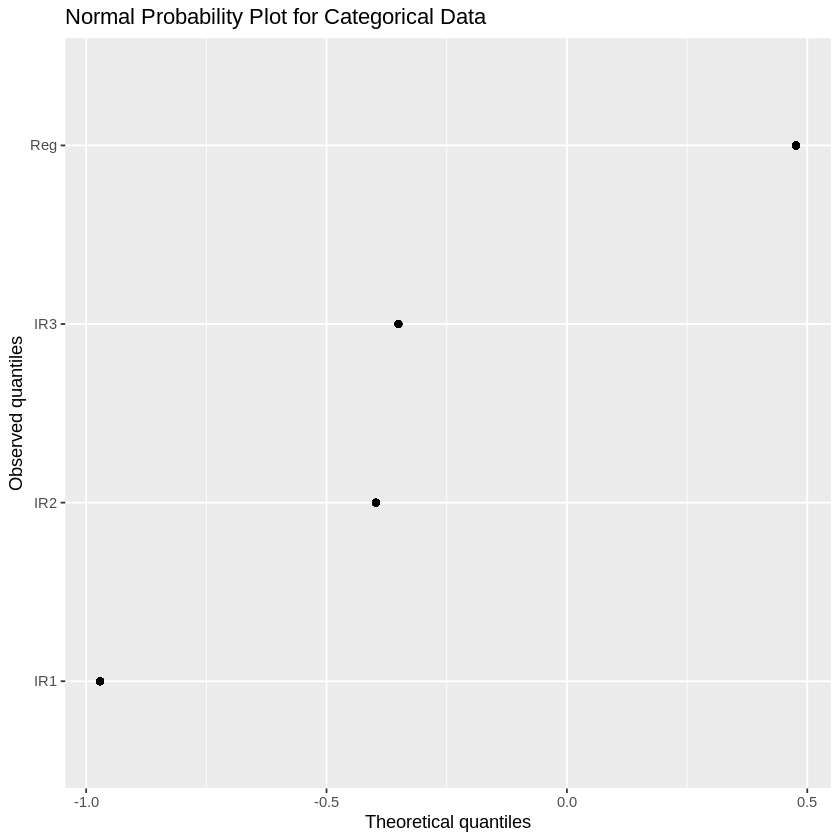

In [ ]:
q <- qnorm((rank(data$LotShape) - 0.5) / length(data$LotShape))

ggplot(data.frame(x = q, y = data$LotShape), aes(x = x, y = y)) +
  geom_point() +
  stat_smooth(method = "lm") +
  xlab("Theoretical quantiles") +
  ylab("Observed quantiles") +
  ggtitle("Normal Probability Plot for Categorical Data")

## Relation between Sale Price and Veneer type

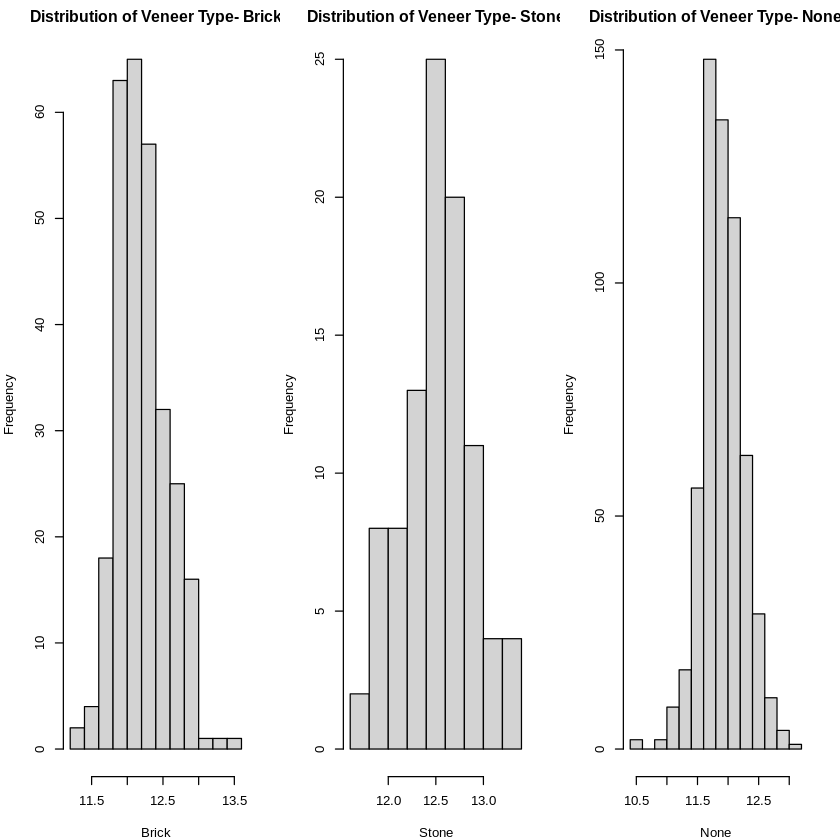

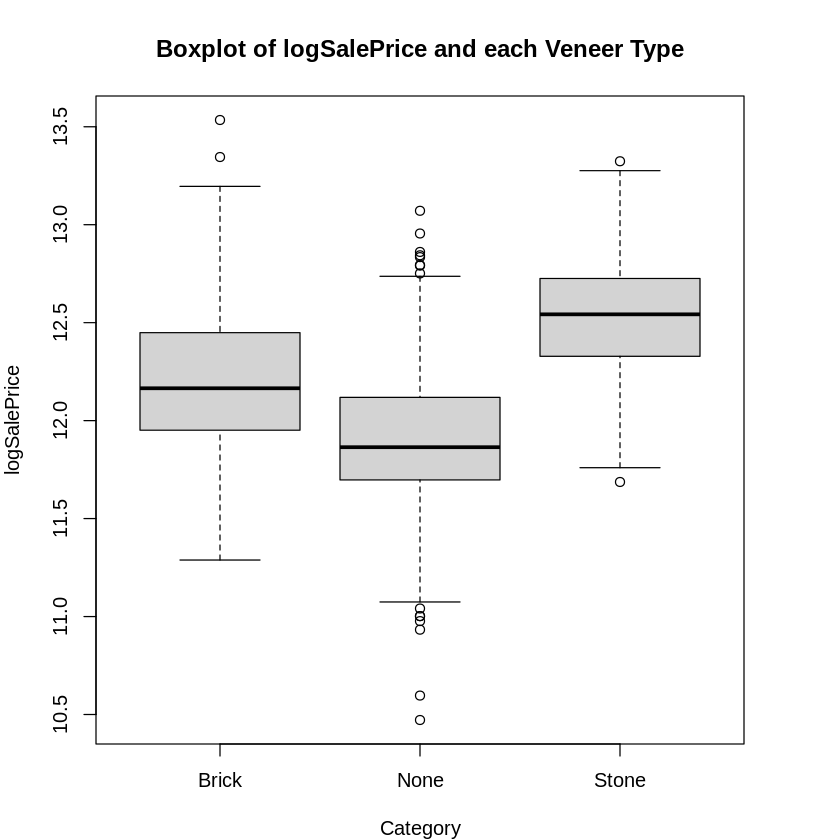

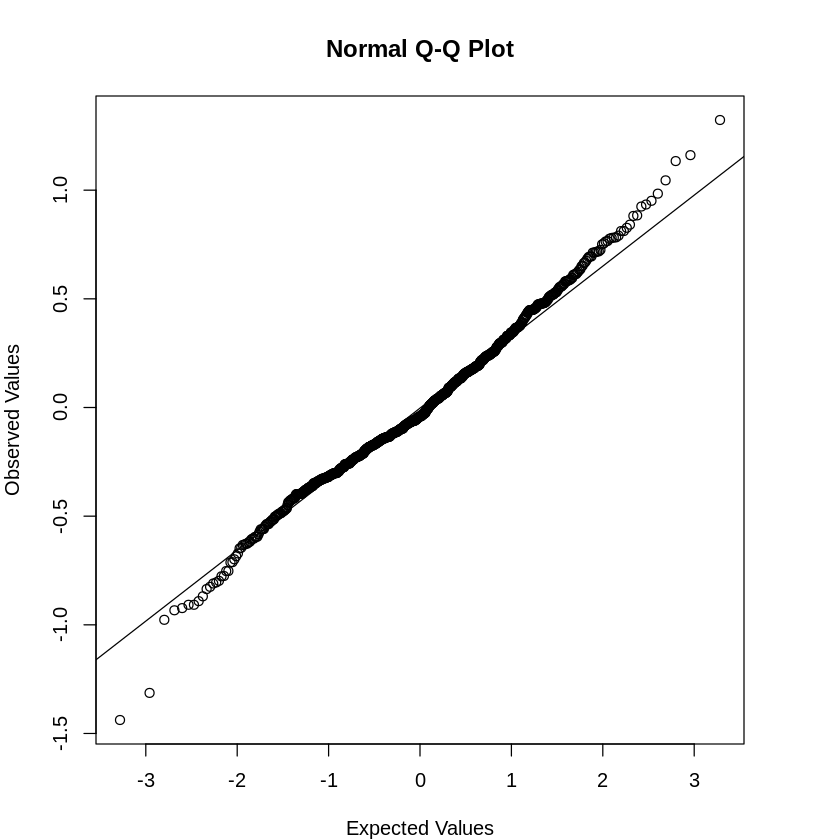

In [ ]:
## check assumptions of anova

#1. Normality
# The dependent variable (logSalePrice) should be approximately normally distributed in each group
par(mfrow=c(1,3), mar=c(4,4,2,2))
hist(filtered$logSalePrice[filtered$MasVnrType == "Brick"], main= "Distribution of Veneer Type- Brick", xlab="Brick")

hist(filtered$logSalePrice[filtered$MasVnrType == "Stone"], main= "Distribution of Veneer Type- Stone", xlab="Stone")

hist(filtered$logSalePrice[filtered$MasVnrType == "None"], main= "Distribution of Veneer Type- None", xlab="None")

#2. Homogeneity of Variance
# The variance of the dependent variable should be approximately equal across all groups.
par(mfrow=c(1,1), mar=c(4,4,4,4))
boxplot(filtered$logSalePrice~filtered$MasVnrType, main="Boxplot of logSalePrice and each Veneer Type", xlab="Category", ylab="logSalePrice")

#3. Independence
## The observations within each group are independent of each other

#4. Normality of Residuals
# Fit ANOVA model
spveneer_linreg <- lm(logSalePrice ~ factor(MasVnrType), data = filtered)
# Check normality of residuals
resid <- residuals(spveneer_linreg)
#qqplot: if approximately straight line then residuals are normally distributed
qqnorm(resid, xlab = "Expected Values", ylab = "Observed Values")
qqline(resid)


In [ ]:
# performing anova test on logSalePrice and MasVnrType
anova1 <- aov(logSalePrice ~ MasVnrType, data = filtered)
summary(anova1)

             Df Sum Sq Mean Sq F value Pr(>F)    
MasVnrType    2  39.26  19.631   162.6 <2e-16 ***
Residuals   968 116.84   0.121                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [ ]:
# pairwise t-test to identify where the differences are
pairwise.t.test(filtered$logSalePrice, filtered$MasVnrType, p.adjust.method = "bonferroni")


	Pairwise comparisons using t tests with pooled SD 

data:  filtered$logSalePrice and filtered$MasVnrType 

      Brick   None   
None  < 2e-16 -      
Stone 1.8e-12 < 2e-16

P value adjustment method: bonferroni 

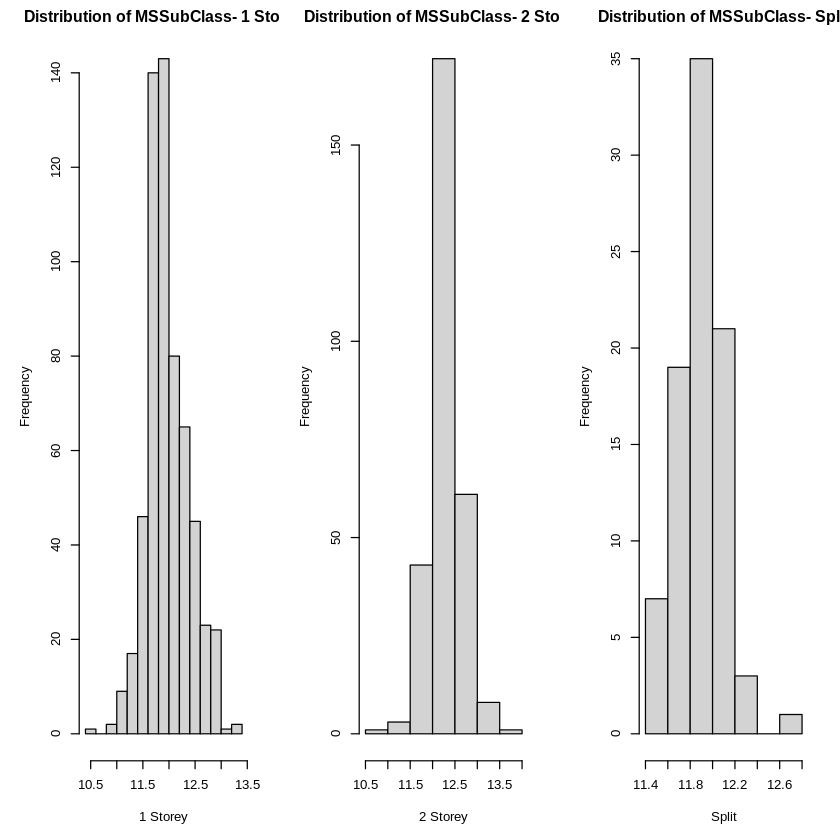

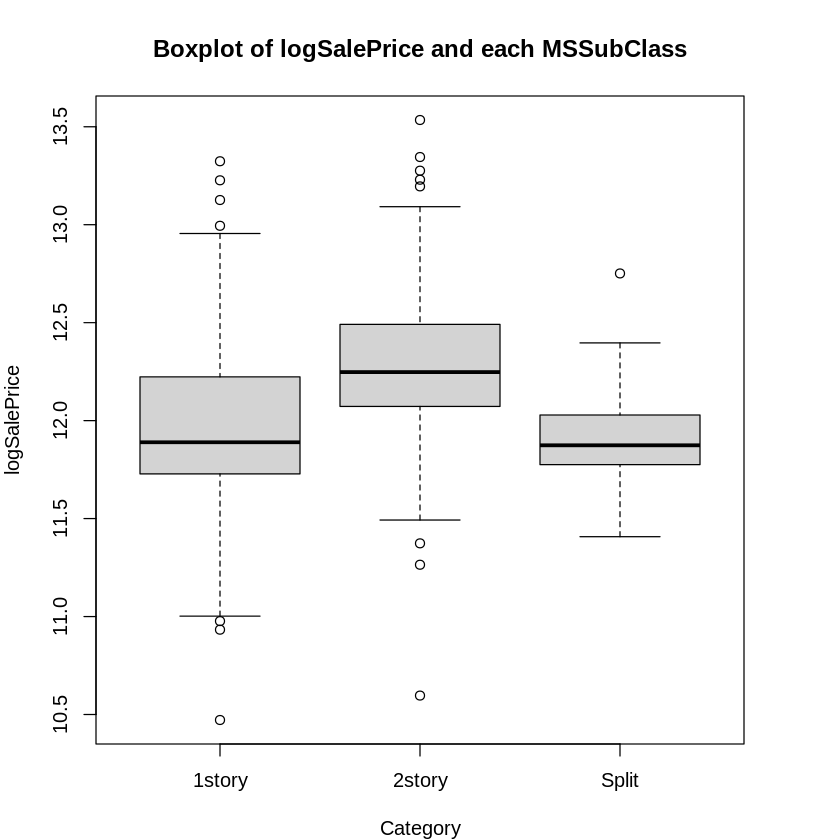

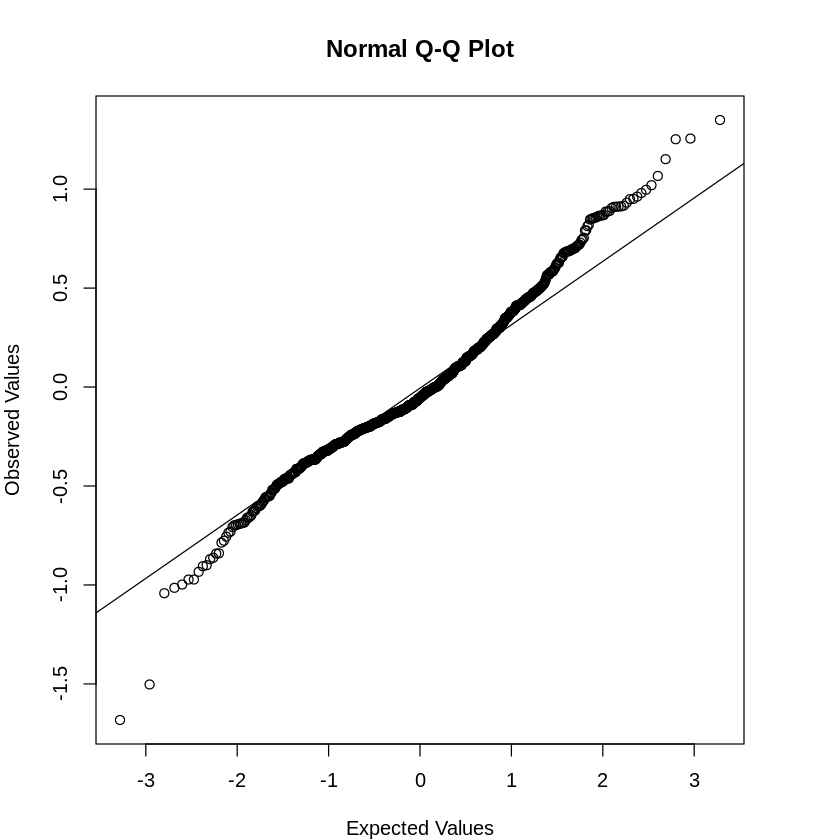

In [ ]:
#1. Normality
# The dependent variable (logSalePrice) should be approximately normally distributed in each group
par(mfrow=c(1,3), mar=c(5,5,2,2))
hist(filtered$logSalePrice[filtered$MSSubClass == "1story"], main= "Distribution of MSSubClass- 1 Storey", xlab="1 Storey")

hist(filtered$logSalePrice[filtered$MSSubClass == "2story"], main= "Distribution of MSSubClass- 2 Storey", xlab="2 Storey")

hist(filtered$logSalePrice[filtered$MSSubClass == "Split"], main= "Distribution of MSSubClass- Split", xlab="Split")

#2. Homogeneity of Variance
# The variance of the dependent variable should be approximately equal across all groups.
par(mfrow=c(1,1), mar=c(4,4,4,4))
boxplot(filtered$logSalePrice~filtered$MSSubClass, main="Boxplot of logSalePrice and each MSSubClass", xlab="Category", ylab="logSalePrice")

#3. Independence
## The observations within each group are independent of each other

#4. Normality of Residuals
# Fit ANOVA model
spveneer_linreg <- lm(logSalePrice ~ factor(MSSubClass), data = filtered)
# Check normality of residuals
resid <- residuals(spveneer_linreg)
#qqplot: if approximately straight line then residuals are normally distributed
qqnorm(resid, xlab = "Expected Values", ylab = "Observed Values")
qqline(resid)

In [ ]:
anova2 <- aov(logSalePrice ~ MSSubClass, data = filtered)
summary(anova2)

             Df Sum Sq Mean Sq F value Pr(>F)    
MSSubClass    2  20.77   10.39   74.29 <2e-16 ***
Residuals   968 135.33    0.14                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [ ]:
# pairwise t-test to identify where the differences are
pairwise.t.test(filtered$logSalePrice, filtered$MSSubClass, p.adjust.method = "bonferroni")


	Pairwise comparisons using t tests with pooled SD 

data:  filtered$logSalePrice and filtered$MSSubClass 

       1story 2story
2story <2e-16 -     
Split  0.12   <2e-16

P value adjustment method: bonferroni 